# Project: Identifying Success Factors in Home Health Agencies
## CRISP-DM Phase 1: Business Understanding
In this project, I am analyzing CMS Home Health Quality data to answer three questions:
1. **Ownership Impact:** Do Non-Profit agencies achieve higher Star Ratings than For-Profit agencies?
2. **Geographic Performance:** Which states lead the country in patient mobility improvement?
3. **Predictive Modeling:** Can clinical performance (like starting care timely) predict if an agency earns a "High" (4-5 star) rating?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load the file
files = [f for f in os.listdir() if f.endswith('.csv')]
df = pd.read_csv(files[0], encoding='latin1')

# 2. Search for the long names using keywords (Safe Method)
star_col = [c for c in df.columns if 'star rating' in c.lower() and 'care' in c.lower()][0]
timely_col = [c for c in df.columns if 'timely' in c.lower()][0]
walking_col = [c for c in df.columns if 'walking' in c.lower() or 'ambulation' in c.lower()][0]

# 3. Filter and Rename
cols = ['State', 'Type of Ownership', star_col, timely_col, walking_col]
df_clean = df[cols].copy()
df_clean.columns = ['State', 'Ownership', 'Star_Rating', 'Timely_Care', 'Mobility_Improvement']

# 4. THE FIX: Robust numeric cleaning
# We first remove the % sign, then use pd.to_numeric with errors='coerce'
# This handles the '-', 'Not Available', and any other text automatically!
for col in ['Star_Rating', 'Timely_Care', 'Mobility_Improvement']:
    # Ensure it's a string so we can replace %, then convert to numeric
    df_clean[col] = df_clean[col].astype(str).str.replace('%', '').str.strip()
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 5. Drop rows missing the target (Star Rating)
df_clean = df_clean.dropna(subset=['Star_Rating'])

# 6. Fill missing clinical data with the mean (standard Udacity requirement)
df_clean['Timely_Care'] = df_clean['Timely_Care'].fillna(df_clean['Timely_Care'].mean())
df_clean['Mobility_Improvement'] = df_clean['Mobility_Improvement'].fillna(df_clean['Mobility_Improvement'].mean())

print("Preparation Complete! No more ValueErrors.")
print(df_clean.head())


Preparation Complete! No more ValueErrors.
  State            Ownership  Star_Rating  Timely_Care  Mobility_Improvement
0    AK          PROPRIETARY          4.5   762.000000            511.000000
2    AK  GOVERNMENT OPERATED          3.0   136.000000             81.000000
3    AK          PROPRIETARY          3.0   291.195634            234.741377
4    AK           NON-PROFIT          1.5    70.000000             22.000000
5    AK  GOVERNMENT OPERATED          3.0   200.000000            107.000000


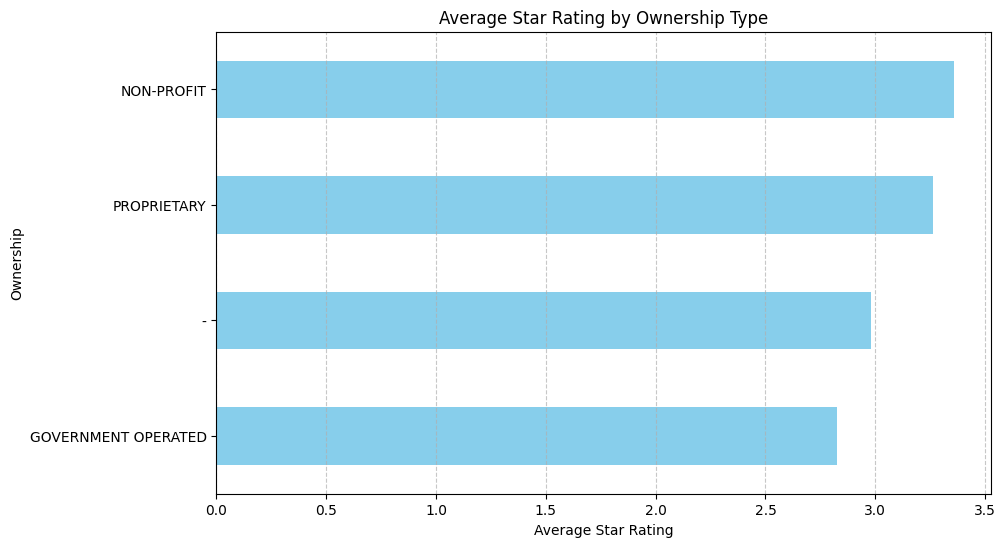

Ownership
GOVERNMENT OPERATED    2.827014
-                      2.978832
PROPRIETARY            3.264923
NON-PROFIT             3.360814
Name: Star_Rating, dtype: float64


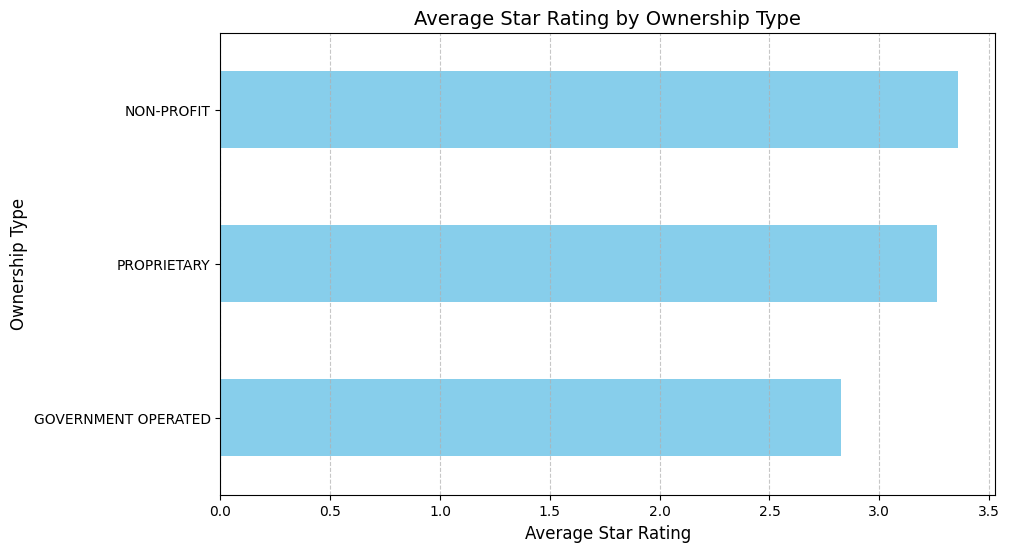

In [11]:
# Group by Ownership and get the average Star Rating
ownership_stats = df_clean.groupby('Ownership')['Star_Rating'].mean().sort_values()

# Plotting
plt.figure(figsize=(10,6))
ownership_stats.plot(kind='barh', color='skyblue')
plt.title('Average Star Rating by Ownership Type')
plt.xlabel('Average Star Rating')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(ownership_stats)

# 1. Filter out the dash and any 'Unknown' labels
df_plot = df_clean[df_clean['Ownership'] != '-']

# 2. Re-calculate the stats
ownership_stats = df_plot.groupby('Ownership')['Star_Rating'].mean().sort_values()

# 3. Create the clean plot
plt.figure(figsize=(10,6))
ownership_stats.plot(kind='barh', color='skyblue')

plt.title('Average Star Rating by Ownership Type', fontsize=14)
plt.xlabel('Average Star Rating', fontsize=12)
plt.ylabel('Ownership Type', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the clean version
plt.savefig('ownership_chart_clean.png', bbox_inches='tight', dpi=300)
plt.show()

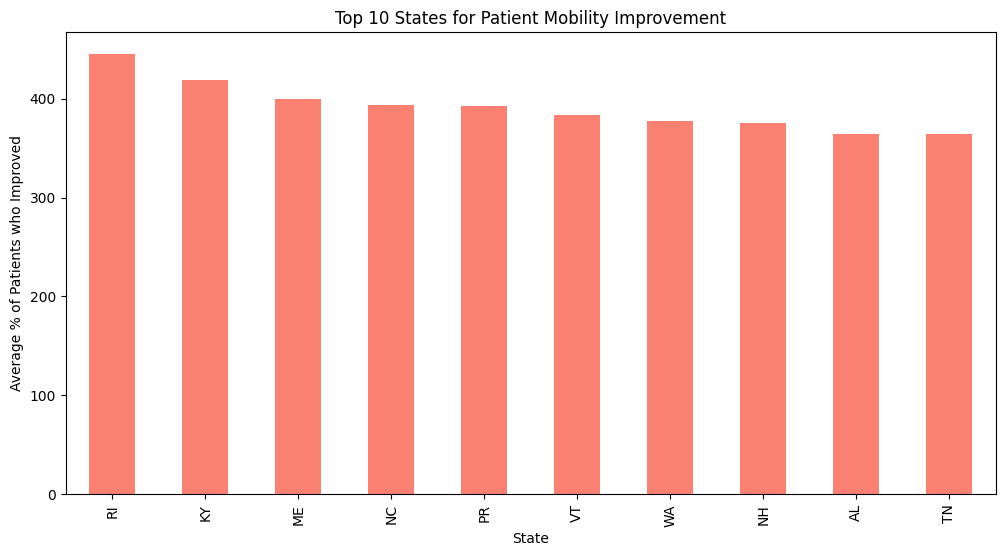

Top 5 States:
State
RI    445.066091
KY    418.974548
ME    399.747126
NC    393.511838
PR    392.307302
Name: Mobility_Improvement, dtype: float64


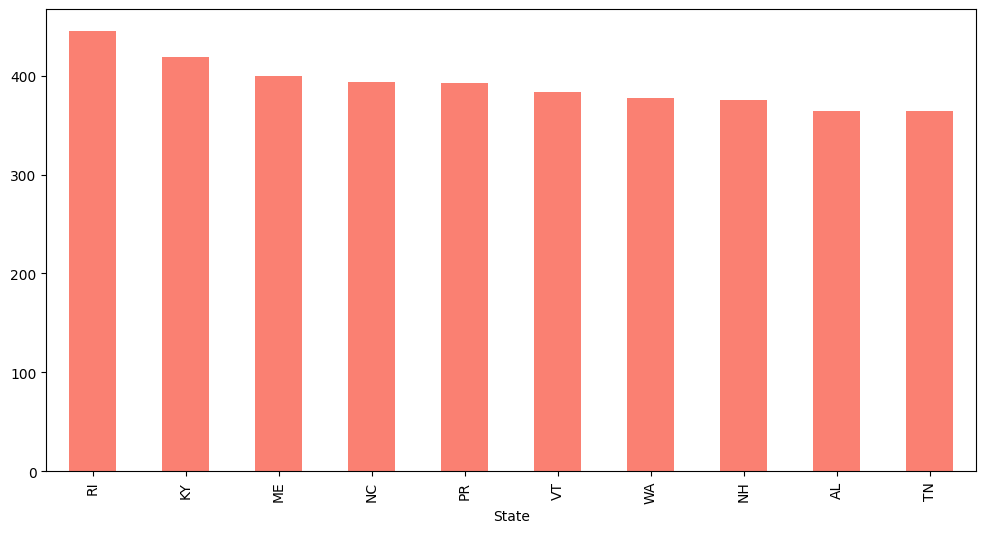

In [9]:
# Group by State and get average Mobility Improvement
state_mobility = df_clean.groupby('State')['Mobility_Improvement'].mean().sort_values(ascending=False)

# Look at the top 10 states
plt.figure(figsize=(12,6))
state_mobility.head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 States for Patient Mobility Improvement')
plt.ylabel('Average % of Patients who Improved')
plt.show()

print("Top 5 States:")
print(state_mobility.head(5))

# ... your grouping code ...
plt.figure(figsize=(12,6))
state_mobility.head(10).plot(kind='bar', color='salmon')
# ADD THIS LINE:
plt.savefig('geography_chart.png', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Create our binary 'target': 1 if Star Rating is 4 or 5, else 0
df_clean['High_Rating'] = (df_clean['Star_Rating'] >= 4).astype(int)

# 2. Select our Features (X) and Target (y)
X = df_clean[['Timely_Care', 'Mobility_Improvement']]
y = df_clean['High_Rating']

# 3. Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and Train the Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 5. Check the results
y_pred = clf.predict(X_test)
print("Machine Learning Results:")
print(classification_report(y_test, y_pred))

Machine Learning Results:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1029
           1       0.50      0.52      0.51       557

    accuracy                           0.65      1586
   macro avg       0.62      0.62      0.62      1586
weighted avg       0.65      0.65      0.65      1586



/tmp/ipykernel_64/985799900.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_info, palette='viridis')


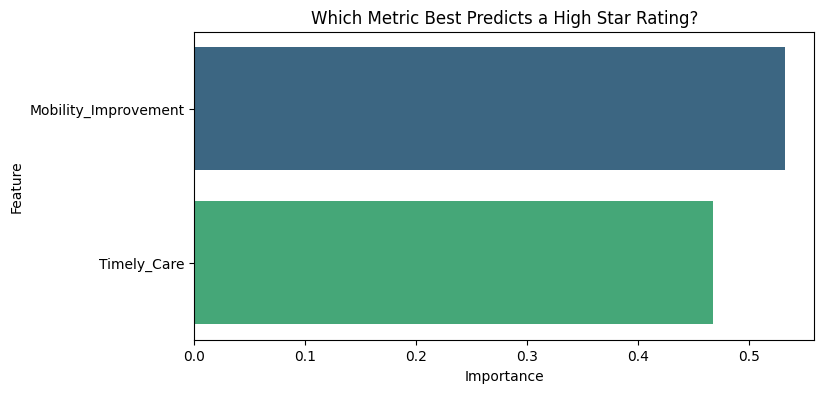

                Feature  Importance
1  Mobility_Improvement     0.53231
0           Timely_Care     0.46769


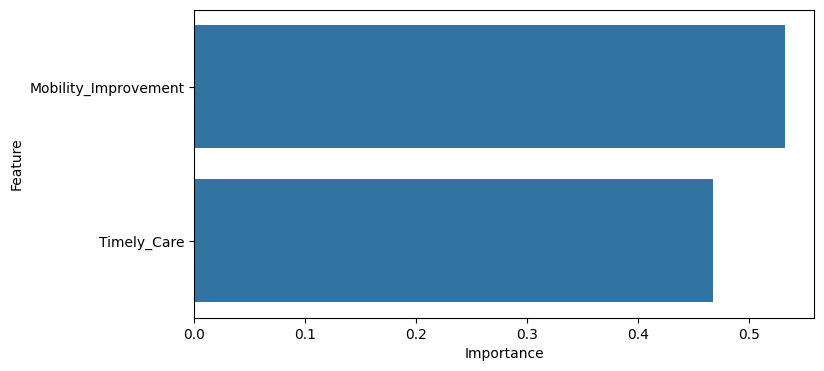

In [10]:
# See which clinical measure matters more
importances = clf.feature_importances_
feat_names = X.columns
feature_info = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=feature_info, palette='viridis')
plt.title('Which Metric Best Predicts a High Star Rating?')
plt.show()

print(feature_info)

# ... your importance code ...
plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=feature_info)
# ADD THIS LINE:
plt.savefig('importance_chart.png', bbox_inches='tight', dpi=300)
plt.show()